## Step 2 Unet Train

In [ ]:
!pip install fastai

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [3]:
## show the ful res image
path_ori_path = Path("/home/jovyan/work/workspace/Xikun_Reps/FOSS4G/Unet_burnt_area")
path_img_ori = path_ori_path/'Train_image.png'
img_ori = open_image(path_img_ori)

In [4]:
path_img_ori_2 = path_ori_path/'Train_3bands.png'
img_ori_2 = open_image(path_img_ori_2)

In [ ]:
img_ori_2.show(figsize=(20,20))

In [ ]:
img_ori.show(figsize=(20,20))

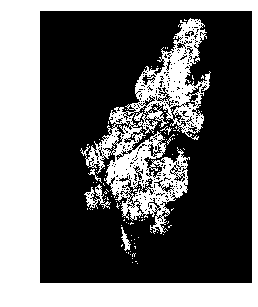

In [5]:
path_lbl_ori = path_ori_path/'Label_withinPoly.png'
lbl_ori = open_image(path_lbl_ori)
lbl_ori.show(figsize=(5,5))

In [9]:
print(lbl_ori)
lbl_ori_np = np.array(lbl_ori)

Image (3, 4933, 3839)


In [10]:
lbl_ori_np

array(Image (3, 4933, 3839), dtype=object)

In [ ]:
max_v = np.max(lbl_ori_np, axis = 2)

In [11]:
size = np.array(lbl_ori.size)
size

array([4933, 3839])

In [ ]:
# src_size = np.array(mask.shape[1:])
# print(src_size)
# mask.data

In [ ]:
mask = open_mask(path_lbl_ori)
# mask.show(figsize=(20,20))

In [14]:
print(mask)
mask.data

ImageSegment (1, 4933, 3839)


tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])

## Check the dataset

In [ ]:
## dataset root path
path = Path("/home/jovyan/work/workspace/Xikun_Reps/FOSS4G/Unet_burnt_area/Data")
path.ls()

In [6]:
## dataset path
path_lbl = path/'Train_300/Labels_300_allMixed'
path_img = path/'Train_300/Images_300_allMixed'

In [7]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/jovyan/work/workspace/Xikun_Reps/FOSS4G/Unet_burnt_area/Data/Train_300/Images_300_allMixed/IMG-783.png'),
 PosixPath('/home/jovyan/work/workspace/Xikun_Reps/FOSS4G/Unet_burnt_area/Data/Train_300/Images_300_allMixed/IMG-140.png'),
 PosixPath('/home/jovyan/work/workspace/Xikun_Reps/FOSS4G/Unet_burnt_area/Data/Train_300/Images_300_allMixed/IMG-311.png')]

In [8]:
lbl_names = get_image_files(path_lbl)
lbl_names[:10]

[PosixPath('/home/jovyan/work/workspace/Xikun_Reps/FOSS4G/Unet_burnt_area/Data/Train_300/Labels_300_allMixed/IMG-783.png'),
 PosixPath('/home/jovyan/work/workspace/Xikun_Reps/FOSS4G/Unet_burnt_area/Data/Train_300/Labels_300_allMixed/IMG-140.png'),
 PosixPath('/home/jovyan/work/workspace/Xikun_Reps/FOSS4G/Unet_burnt_area/Data/Train_300/Labels_300_allMixed/IMG-311.png'),
 PosixPath('/home/jovyan/work/workspace/Xikun_Reps/FOSS4G/Unet_burnt_area/Data/Train_300/Labels_300_allMixed/IMG-400.png'),
 PosixPath('/home/jovyan/work/workspace/Xikun_Reps/FOSS4G/Unet_burnt_area/Data/Train_300/Labels_300_allMixed/IMG-247.png'),
 PosixPath('/home/jovyan/work/workspace/Xikun_Reps/FOSS4G/Unet_burnt_area/Data/Train_300/Labels_300_allMixed/IMG-301.png'),
 PosixPath('/home/jovyan/work/workspace/Xikun_Reps/FOSS4G/Unet_burnt_area/Data/Train_300/Labels_300_allMixed/IMG-97.png'),
 PosixPath('/home/jovyan/work/workspace/Xikun_Reps/FOSS4G/Unet_burnt_area/Data/Train_300/Labels_300_allMixed/IMG-27.png'),
 PosixPath

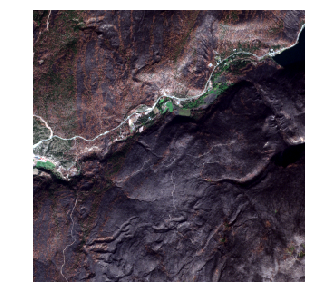

In [9]:
img_f = fnames[5]
img = open_image(img_f)
img.show(figsize=(5,5))

In [10]:
get_y_fn = lambda x: path_lbl/f'{x.stem}{x.suffix}'

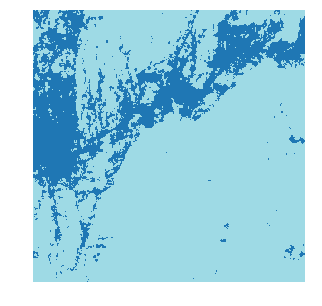

In [11]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [12]:
len(fnames), len(lbl_names)

(900, 900)

In [422]:
mask.data

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])

# Make DataBunch

In [13]:
size = 300
bs = 8

In [424]:
# def get_y_fn(x):
#     return Path(str(x)+'labels')/x.name

In [60]:
# one class
codes = np.array(['unburnt','burnt'])

In [61]:
class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)

class SegItemListCustom(SegmentationItemList):
    _label_cls = SegLabelListCustom

In [62]:
src = (SegItemListCustom.from_folder(path_img)
        .split_by_rand_pct()
        .label_from_func(get_y_fn, classes=codes))

In [63]:
tfms = get_transforms(flip_vert=True, max_warp=0, max_zoom=1.2, max_lighting=0.3)
data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=bs, num_workers = 0)
        .normalize(imagenet_stats))

In [64]:
data

ImageDataBunch;

Train: LabelList (720 items)
x: SegItemListCustom
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: SegLabelListCustom
ImageSegment (1, 300, 300),ImageSegment (1, 300, 300),ImageSegment (1, 300, 300),ImageSegment (1, 300, 300),ImageSegment (1, 300, 300)
Path: /home/jovyan/work/workspace/Xikun_Reps/FOSS4G/Unet_burnt_area/Data/Train_300/Images_300_allMixed;

Valid: LabelList (180 items)
x: SegItemListCustom
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: SegLabelListCustom
ImageSegment (1, 300, 300),ImageSegment (1, 300, 300),ImageSegment (1, 300, 300),ImageSegment (1, 300, 300),ImageSegment (1, 300, 300)
Path: /home/jovyan/work/workspace/Xikun_Reps/FOSS4G/Unet_burnt_area/Data/Train_300/Images_300_allMixed;

Test: None

In [19]:
data.valid_ds.items

array([PosixPath('/home/jovyan/work/workspace/Xikun_Reps/FOSS4G/Unet_burnt_area/Data/Train_300/Images_300_allMixed/IMG-94.png'),
       PosixPath('/home/jovyan/work/workspace/Xikun_Reps/FOSS4G/Unet_burnt_area/Data/Train_300/Images_300_allMixed/IMG-777.png'),
       PosixPath('/home/jovyan/work/workspace/Xikun_Reps/FOSS4G/Unet_burnt_area/Data/Train_300/Images_300_allMixed/IMG-814.png'),
       PosixPath('/home/jovyan/work/workspace/Xikun_Reps/FOSS4G/Unet_burnt_area/Data/Train_300/Images_300_allMixed/IMG-72.png'),
       ...,
       PosixPath('/home/jovyan/work/workspace/Xikun_Reps/FOSS4G/Unet_burnt_area/Data/Train_300/Images_300_allMixed/IMG-478.png'),
       PosixPath('/home/jovyan/work/workspace/Xikun_Reps/FOSS4G/Unet_burnt_area/Data/Train_300/Images_300_allMixed/IMG-189.png'),
       PosixPath('/home/jovyan/work/workspace/Xikun_Reps/FOSS4G/Unet_burnt_area/Data/Train_300/Images_300_allMixed/IMG-539.png'),
       PosixPath('/home/jovyan/work/workspace/Xikun_Reps/FOSS4G/Unet_burnt_area/

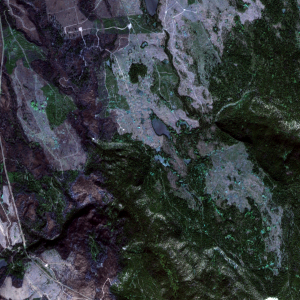

In [20]:
data.train_ds.x[8]

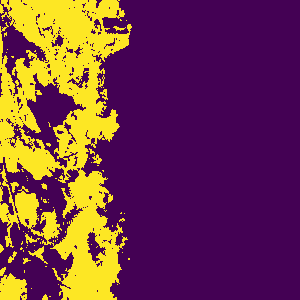

In [21]:
data.train_ds.y[8]

In [98]:
data.train_ds.y[8].data

tensor([[[0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         ...,
         [0, 0, 0,  ..., 1, 0, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1]]])

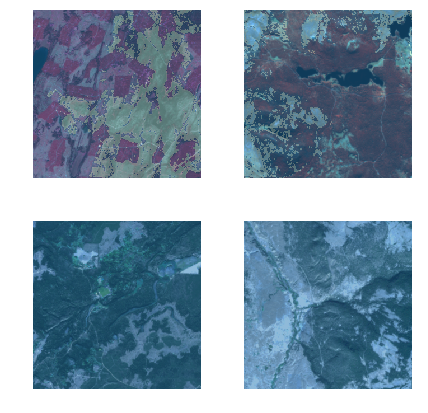

In [123]:
data.show_batch(2,figsize=(6,6), alpha=0.5)

In [ ]:
data.show_batch(12,figsize=(6,6), ds_type=DatasetType.Valid, alpha=0)

In [101]:
data.classes

array(['unburnt', 'burnt'], dtype='<U7')

## Custom Loss

In [24]:
import pdb

In [65]:
def dice_loss(input, target):
#     pdb.set_trace()
    smooth = 1.
    input = input[:,1,None].sigmoid()
    iflat = input.contiguous().view(-1).float()
    tflat = target.view(-1).float()
    intersection = (iflat * tflat).sum()
    return (1 - ((2. * intersection + smooth) / ((iflat + tflat).sum() +smooth)))

def combo_loss(pred, targ):
    bce_loss = CrossEntropyFlat(axis=1)
    return bce_loss(pred,targ) + dice_loss(pred,targ)

In [104]:
# def dice(input, target):
#     input = torch.relu(input)
#     inputs = (input > 0.5).float()
#     targets = target.float()
#     return 2. * (inputs * targets).sum() / (inputs.sum() + targets.sum())

In [83]:
def dice(input:Tensor, targs:Tensor, iou:bool=False, eps:float=1e-8)->Rank0Tensor:
#     "Dice coefficient metric for binary target. If iou=True, returns iou metric, classic for segmentation problems."
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    targs = targs.view(n,-1)
    intersect = (input * targs).sum(dim=1).float()
    union = (input+targs).sum(dim=1).float()
    if not iou: l = 2. * intersect / union
    else: l = intersect / (union-intersect+eps)
    l[union == 0.] = 1.
    return l.mean()

## Define Model

In [84]:
def acc_fixed(input, targs):
    n = targs.shape[0]
    targs = targs.squeeze(1)
    targs = targs.view(n,-1)
    input = input.argmax(dim=1).view(n,-1)
    return (input==targs).float().mean()

def acc_thresh(input:Tensor, target:Tensor, thresh:float=0.5, sigmoid:bool=True)->Rank0Tensor:
#     "Compute accuracy when `y_pred` and `y_true` are the same size."
    
#     pdb.set_trace()
    if sigmoid: input = input.sigmoid()
    n = input.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    target = target.view(n,-1)
    return ((input>thresh)==target.byte()).float().mean()
    

In [85]:
# iou = partial(dice, iou=True)
metrics = [dice_loss, acc_fixed, dice]

In [87]:
learn = unet_learner(data, models.resnet18, metrics=metrics)#.load("/home/jovyan/work/workspace/Xikun_Reps/FOSS4G/Unet_burnt_area/Data/Saved_Model/export_final_1")

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/jovyan/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 56593461.86it/s]


In [88]:
learn.metrics = metrics

In [90]:
learn.loss_func = combo_loss
learn.loss_func

<function __main__.combo_loss(pred, targ)>

In [91]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [ ]:
learn.recorder.plot()

In [56]:
from fastai.callbacks import *

# small change to SaveModelCallback() to add printouts
@dataclass
class SaveModelCallbackVerbose(TrackerCallback):
#     "A `TrackerCallback` that saves the model when monitored quantity is best."
    every:str='improvement'
    name:str='bestmodel'
    def __post_init__(self):
        if self.every not in ['improvement', 'epoch']:
            warn(f'SaveModel every {self.every} is invalid, falling back to "improvement".')
            self.every = 'improvement'
        super().__post_init__()

    def on_epoch_end(self, epoch, **kwargs:Any)->None:
        if self.every=="epoch": self.learn.save(f'{self.name}_{epoch}')
        else: #every="improvement"
            current = self.get_monitor_value()
            if current is not None and self.operator(current, self.best):
                self.best = current
                self.learn.save(f'{self.name}')
                print(f'saved model at epoch {epoch} with {self.monitor} value: {current}')

    def on_train_end(self, **kwargs):
        if self.every=="improvement": self.learn.load(f'{self.name}')

In [138]:
lr = 1e-3

In [94]:
# learn.data.train_ds.tfmargs['size'] = None
# learn.data.valid_ds.tfmargs['size'] = None
# learn.data.single_dl.dataset.tfmargs['size'] = None

In [ ]:
learn.fit_one_cycle(5, max_lr=lr, 
                    callbacks=[
                        SaveModelCallback(learn,
                                                 every='epoch',
                                                 monitor='dice',
                                                 mode='auto',
                                                 name='2019-FOSS4G-rn18unet-comboloss-alldata-300-best-mixed')
                    ]
                   )

In [96]:
learn.unfreeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [141]:
# adjust the lr into smaller
lr=1e-4
learn.fit_one_cycle(10, slice(lr), pct_start=0.7)

epoch,train_loss,valid_loss,dice_loss,acc_fixed,dice,time
0,0.351593,0.326383,0.163046,0.936540,0.680355,13:31
1,0.322314,0.314574,0.155492,0.937391,0.646532,13:27
2,0.334334,0.313866,0.157450,0.938089,0.688511,13:20
3,0.332906,0.315363,0.158930,0.938496,0.705832,13:09
4,0.313575,0.312840,0.159351,0.939520,0.723006,13:40
5,0.317208,0.305085,0.154772,0.939640,0.704090,15:14
6,0.313951,0.298159,0.149408,0.940734,0.703231,13:08
7,0.314093,0.294686,0.148893,0.941636,0.728294,13:02
8,0.286822,0.291963,0.147490,0.942566,0.717409,13:03
9,0.280460,0.289968,0.144805,0.942015,0.687311,12:56


In [147]:
learn.unfreeze()
lrs = slice(lr/100,lr)
learn.fit_one_cycle(5, lrs, pct_start=0.6)

epoch,train_loss,valid_loss,dice_loss,acc_fixed,dice,time
0,0.279859,0.291797,0.147076,0.943045,0.710645,12:48
1,0.270778,0.290592,0.145173,0.943182,0.729469,12:43
2,0.300017,0.292406,0.149647,0.943263,0.750395,12:50
3,0.298735,0.285170,0.145367,0.943910,0.758661,12:47
4,0.293196,0.283102,0.142816,0.943305,0.743603,12:54


In [126]:
outputs = learn.pred_batch(ds_type=DatasetType.Valid)

In [197]:
outputs.shape

torch.Size([8, 2, 512, 512])

In [ ]:
for i in range(bs):

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

    data.valid_ds.x[i].show(ax=ax1)
    ax1.set_title('Prediction')
    ax1.imshow((to_np(outputs[i][0])), alpha=1)
    
    ax2.set_title('Ground Truth')
    data.valid_ds.x[i].show(ax=ax2, alpha = 1)
    data.valid_ds.y[i].show(ax=ax2, alpha= 1)
    plt.show()

In [ ]:
learn.show_results(rows=20, figsize=(10,50))

In [144]:
save_model_path = "/home/jovyan/work/workspace/Xikun_Reps/FOSS4G/Unet_burnt_area/Data/Model_export/"

In [148]:
learn.save(save_model_path + 'export_300_final_6')

In [149]:
learn.export(file = save_model_path + 'export_300_final_6.pkl')